In [ ]:
# Bibliotecas padrão
import time

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt

# Acesso a datasets do Kaggle
import kagglehub

# Scikit-learn: Modelos
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Scikit-learn: Pré-processamento e pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Scikit-learn: Avaliação de modelos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def classify_maintenance(x):
    if x <= 30:
        return 2  # Crítica
    elif x <= 80:
        return 1  # Preventiva
    else:
        return 0  # Sem necessidade

def download_datasets():
  path = ".." + kagglehub.dataset_download("mhadani/predictive-maintenance-aircraft-engine")
  print("Path to dataset files:", path)
  !cp ../kaggle/input/predictive-maintenance-aircraft-engine/*.csv .
  return path

def calculate_rul_train(df_train):
    rul_train = df_train.groupby("id")["cycle"].max().to_dict()
    df_train["RUL"] = df_train.apply(lambda row: rul_train[row["id"]] - row["cycle"], axis=1)
    df_train["maintenance_level"] = df_train["RUL"].apply(classify_maintenance)
    return df_train

def calculate_rul_test(df_test, df_truth):
    last_cycles = df_test.groupby("id")["cycle"].max()
    truth_rul_dict = df_truth.set_index("id")["cycle"].to_dict()
    final_cycle_dict = {id_: last_cycles[id_] + truth_rul_dict[id_] for id_ in last_cycles.index}
    df_test["RUL"] = df_test.apply(lambda row: final_cycle_dict[row["id"]] - row["cycle"], axis=1)
    df_test["maintenance_level"] = df_test["RUL"].apply(classify_maintenance)
    return df_test

def make_predictions(model, X_test):
  """
  Realiza predições com o modelo fornecido sobre X_test.
  Retorna o vetor de predições y_pred.
  """
  y_pred = model.predict(X_test)
  return y_pred

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_performance(y_test, y_pred, class_names, color_index, title="Matriz de Confusão"):
    """
    Imprime o relatório de classificação e exibe a matriz de confusão.

    Parâmetros:
    - y_test: valores reais
    - y_pred: valores preditos
    - class_names: lista de nomes das classes para exibir
    - color_index: índice do colormap a ser usado
    - title: título do gráfico da matriz de confusão
    """
    print("Classification Report:\n")
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=class_names))

    accuracy = report.get("accuracy", None)
    if accuracy is not None:
        print(f"Acurácia: {accuracy:.4f}\n")

    colormaps = [
        "Blues", "BuGn", "BuPu", "GnBu", "PuBu", "PuBuGn", "YlGnBu",
        "viridis", "plasma", "magma", "cividis", "Reds",
    ]
    if not (0 <= color_index < len(colormaps)):
        raise ValueError(f"color_index deve estar entre 0 e {len(colormaps) - 1}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=colormaps[color_index])
    plt.title(title)
    plt.show()


Path to dataset files: ../kaggle/input/predictive-maintenance-aircraft-engine
Classification Report:

              precision    recall  f1-score   support

      Seguro       0.94      0.96      0.95     11016
  Preventiva       0.65      0.59      0.62      1748
     Crítica       0.81      0.62      0.70       332

    accuracy                           0.90     13096
   macro avg       0.80      0.73      0.76     13096
weighted avg       0.90      0.90      0.90     13096

Acurácia: 0.9025



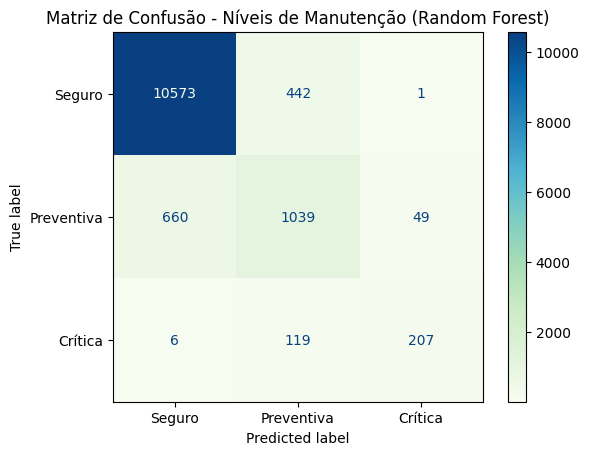

Tempo de treino: 6.5727 segundos


In [ ]:
path = download_datasets()
df_train = pd.read_csv(path + '/PM_train.csv')
df_test = pd.read_csv(path + '/PM_test.csv')
df_truth = pd.read_csv(path + '/PM_truth.csv')

df_train = calculate_rul_train(df_train)

df_test = calculate_rul_test(df_test, df_truth)

# Seleção de features (exclui colunas irrelevantes)
drop_cols = ["id", "RUL", "label", "maintenance_level"] if "label" in df_train.columns else ["id", "RUL", "maintenance_level"]
features = [col for col in df_train.columns if col not in drop_cols]
X_train = df_train[features]
y_train = df_train["maintenance_level"]

X_test = df_test[features]
y_test = df_test["maintenance_level"]

begin = time.time()

# Treinar modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
end = time.time()

time_rf = end - begin

class_names = ["Seguro", "Preventiva", "Crítica"]
y_pred_rf = make_predictions(model, X_test)
evaluate_performance(y_test, y_pred_rf, class_names, 3, title="Matriz de Confusão - Níveis de Manutenção (Random Forest)")

print(f"Tempo de treino: {time_rf:.4f} segundos")


Path to dataset files: ../kaggle/input/predictive-maintenance-aircraft-engine


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:

              precision    recall  f1-score   support

      Seguro       0.93      0.97      0.95     11016
  Preventiva       0.69      0.54      0.60      1748
     Crítica       0.77      0.62      0.68       332

    accuracy                           0.90     13096
   macro avg       0.80      0.71      0.75     13096
weighted avg       0.90      0.90      0.90     13096

Acurácia: 0.9040



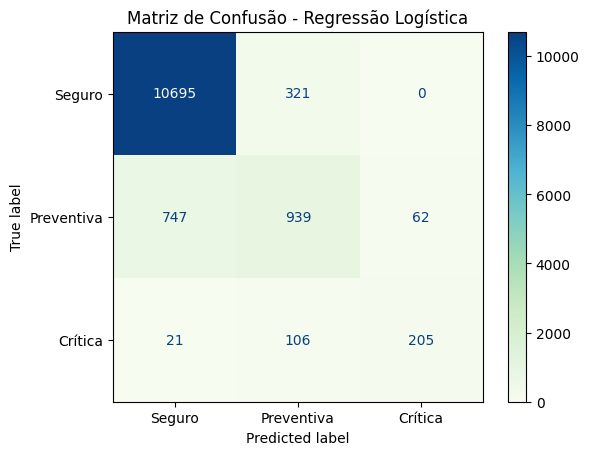

Tempo de treino: 0.9266 segundos


In [ ]:
# Carregar dados e pré-processar
path = download_datasets()
df_train = pd.read_csv(path + '/PM_train.csv')
df_test = pd.read_csv(path + '/PM_test.csv')
df_truth = pd.read_csv(path + '/PM_truth.csv')

df_train = calculate_rul_train(df_train)
df_test = calculate_rul_test(df_test, df_truth)

# Seleção de features
drop_cols = ["id", "RUL", "label", "maintenance_level"] if "label" in df_train.columns else ["id", "RUL", "maintenance_level"]
features = [col for col in df_train.columns if col not in drop_cols]

X_train = df_train[features]
X_test = df_test[features]
y_train = df_train["maintenance_level"]
y_test = df_test["maintenance_level"]

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

begin = time.time()

# Treinar modelo de Regressão Logística
model = LogisticRegression(max_iter=100000, multi_class='multinomial', solver='lbfgs', random_state=42)
model.fit(X_train_scaled, y_train)
end = time.time()

time_lr = end - begin

# Avaliação
class_names = ["Seguro", "Preventiva", "Crítica"]
y_pred_lr = make_predictions(model, X_test_scaled)
evaluate_performance(y_test, y_pred_lr, class_names, 3,title="Matriz de Confusão - Regressão Logística")

print(f"Tempo de treino: {time_lr:.4f} segundos")

Path to dataset files: ../kaggle/input/predictive-maintenance-aircraft-engine
Classification Report:

              precision    recall  f1-score   support

      Seguro       0.93      0.97      0.95     11016
  Preventiva       0.70      0.54      0.61      1748
     Crítica       0.84      0.61      0.71       332

    accuracy                           0.91     13096
   macro avg       0.82      0.71      0.76     13096
weighted avg       0.90      0.91      0.90     13096

Acurácia: 0.9068



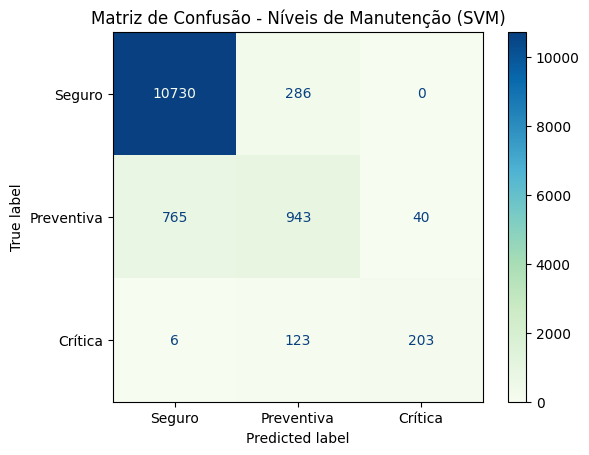

Tempo de treino: 7.9954 segundos


In [ ]:
# Carregar e preparar os dados
path = download_datasets()
df_train = pd.read_csv(path + '/PM_train.csv')
df_test = pd.read_csv(path + '/PM_test.csv')
df_truth = pd.read_csv(path + '/PM_truth.csv')

df_train = calculate_rul_train(df_train)
df_test = calculate_rul_test(df_test, df_truth)

# Seleção de features
drop_cols = ["id", "RUL", "label", "maintenance_level"] if "label" in df_train.columns else ["id", "RUL", "maintenance_level"]
features = [col for col in df_train.columns if col not in drop_cols]
X_train, y_train = df_train[features], df_train["maintenance_level"]
X_test, y_test = df_test[features], df_test["maintenance_level"]

# Normalização (recomendada para SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

begin = time.time()

# Treinar e avaliar o modelo SVM
model = SVC(kernel='rbf', random_state=42)
model.fit(X_train_scaled, y_train)

end = time.time()

time_svm = end - begin

y_pred_svm = make_predictions(model, X_test_scaled)
evaluate_performance(y_test, y_pred_svm, ["Seguro", "Preventiva", "Crítica"], 3,title="Matriz de Confusão - Níveis de Manutenção (SVM)")
print(f"Tempo de treino: {time_svm:.4f} segundos")

Path to dataset files: ../kaggle/input/predictive-maintenance-aircraft-engine
Classification Report:

              precision    recall  f1-score   support

      Seguro       0.91      0.98      0.94     11016
  Preventiva       0.68      0.33      0.45      1748
     Crítica       0.69      0.72      0.70       332

    accuracy                           0.89     13096
   macro avg       0.76      0.68      0.70     13096
weighted avg       0.87      0.89      0.87     13096

Acurácia: 0.8875



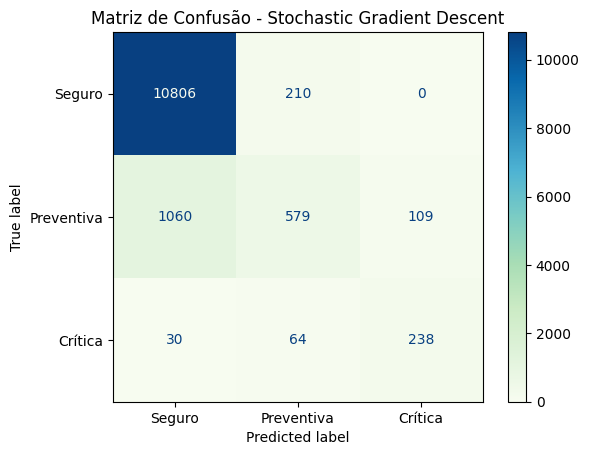

Tempo de treino: 0.4941 segundos


In [69]:
# Carregar e preparar os dados
path = download_datasets()
df_train = pd.read_csv(path + '/PM_train.csv')
df_test = pd.read_csv(path + '/PM_test.csv')
df_truth = pd.read_csv(path + '/PM_truth.csv')

df_train = calculate_rul_train(df_train)
df_test = calculate_rul_test(df_test, df_truth)

# Seleção de features
drop_cols = ["id", "RUL", "label", "maintenance_level"] if "label" in df_train.columns else ["id", "RUL", "maintenance_level"]
features = [col for col in df_train.columns if col not in drop_cols]

X_train, y_train = df_train[features], df_train["maintenance_level"]
X_test, y_test = df_test[features], df_test["maintenance_level"]


# Criar pipeline com escalonamento + SGD
model = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd", SGDClassifier(loss="log_loss", max_iter=100000, tol=1e-3, random_state=42))
])
begin = time.time()
# Treinar o modelo
model.fit(X_train, y_train)
end = time.time()

time_sgd = end - begin

# Fazer previsões
y_pred_sgd = model.predict(X_test)

# Avaliar resultados
evaluate_performance(y_test, y_pred_sgd, ["Seguro", "Preventiva", "Crítica"], 3, title="Matriz de Confusão - Stochastic Gradient Descent")

print(f"Tempo de treino: {time_sgd:.4f} segundos")

<Figure size 1200x600 with 0 Axes>

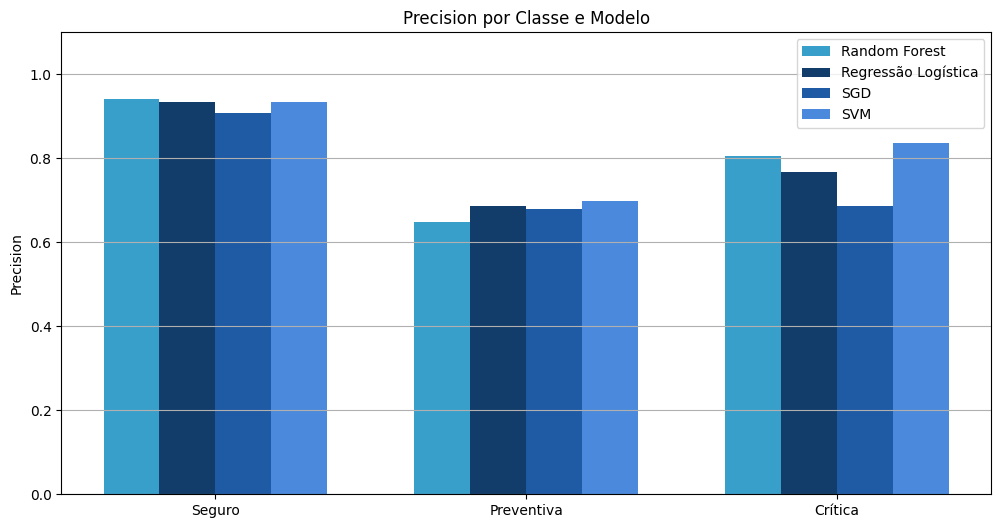

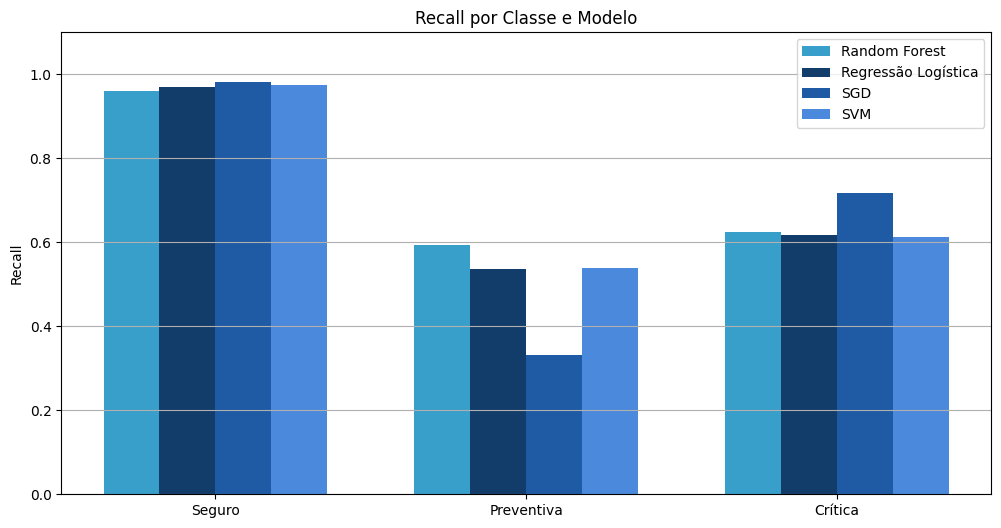

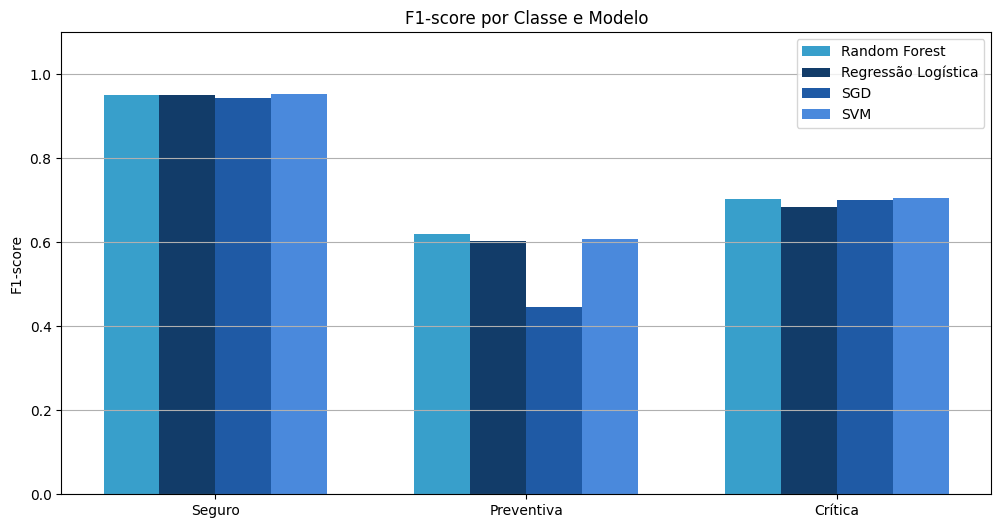

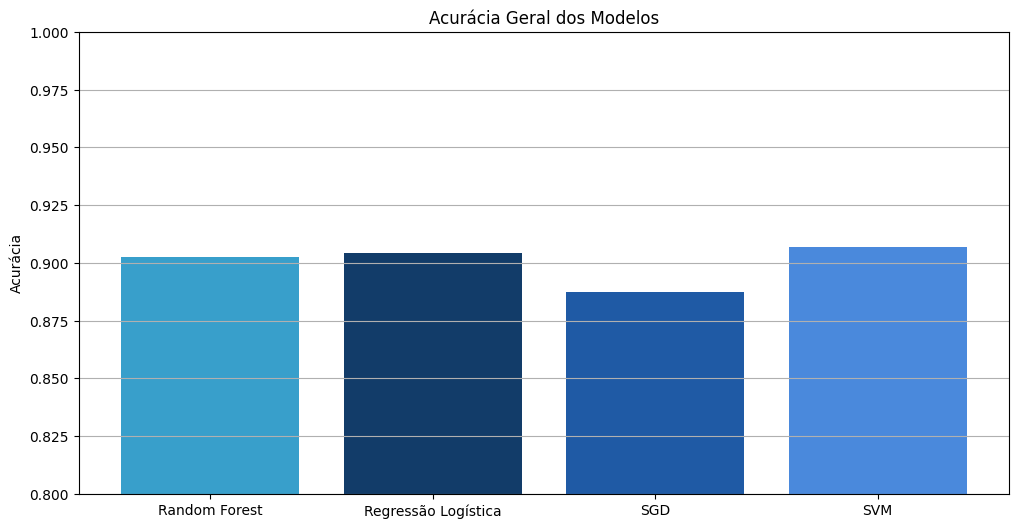

In [71]:
# Exemplo de outputs que você deve ter após rodar os modelos:
# y_test - rótulos reais
# y_pred_rf, y_pred_nb, y_pred_svm, y_pred_lr - predições dos modelos

models_results = {
    "Random Forest": y_pred_rf,
    "Regressão Logística": y_pred_lr,
    "SGD": y_pred_sgd,
    "SVM": y_pred_svm,
}

class_names = ["Seguro", "Preventiva", "Crítica"]

# Função para extrair métricas do classification_report
def get_metrics_dict(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    return report

# Preparar dados para gráficos
metrics_data = {}
accuracies = {}

for name, y_pred in models_results.items():
    report = get_metrics_dict(y_test, y_pred, class_names)
    metrics_data[name] = {
        'precision': [report[c]['precision'] for c in class_names],
        'recall': [report[c]['recall'] for c in class_names],
        'f1-score': [report[c]['f1-score'] for c in class_names],
    }
    accuracies[name] = report['accuracy']

# --- Gráfico 2: Precisão, Recall e F1-score por classe para cada modelo ---
plt.figure(figsize=(12,6))
colors_gnbu = [
    '#389fcb','#123c69', '#1f5aa5', '#4a89dc', '#a3c8f0'
]

metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(class_names))
width = 0.18

for metric in metrics:
    plt.figure(figsize=(12,6))
    for i, (name, data) in enumerate(metrics_data.items()):
        plt.bar(
            x + i*width,
            data[metric],
            width,
            label=name,
            color=colors_gnbu[i % len(colors_gnbu)]
        )
    plt.xticks(x + width*1.5, class_names)
    plt.ylim(0,1.1)
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} por Classe e Modelo")
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# --- Gráfico 3: Acurácia geral dos modelos ---

plt.figure(figsize=(12,6))
plt.bar(accuracies.keys(), accuracies.values(), color=colors_gnbu)
plt.ylim(0.8,1.0)
plt.ylabel('Acurácia')
plt.title('Acurácia Geral dos Modelos')
plt.grid(axis='y')
plt.show()


/tmp/ipython-input-2071419914.py:37: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(colorir_modelos, subset=["Modelo"]) \


,Modelo,Precisão Média,Recall Médio,F1-Score Médio,Acurácia Geral,Tempo (s)
0,Random Forest,79.85%,72.59%,75.79%,90.25%,6.573
1,Regressão Logística,79.61%,70.85%,74.64%,90.40%,0.927
2,SGD,75.77%,67.63%,69.65%,88.75%,0.494
3,SVM,82.19%,70.83%,75.58%,90.68%,7.995


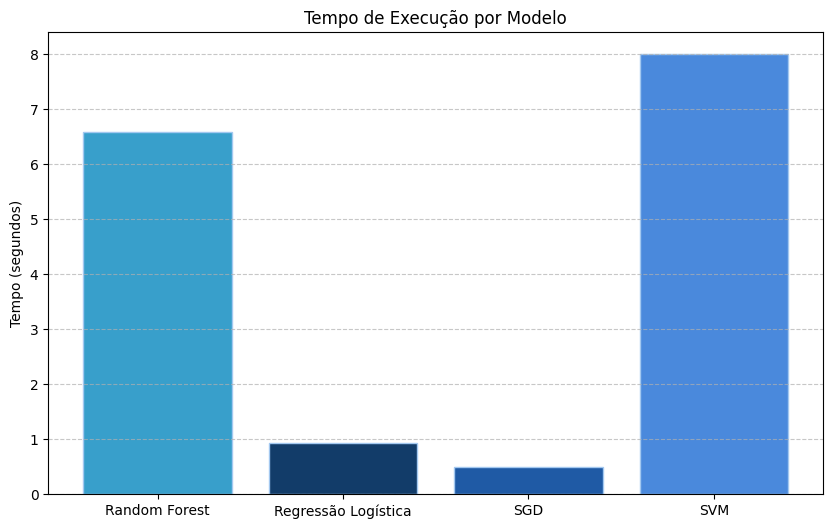

                 Modelo      Classe  Precisão    Recall  F1-Score  \
0         Random Forest      Seguro  0.940742  0.959786  0.950169   
1         Random Forest  Preventiva  0.649375  0.594394  0.620669   
2         Random Forest     Crítica  0.805447  0.623494  0.702886   
3   Regressão Logística      Seguro  0.933002  0.970861  0.951555   
4   Regressão Logística  Preventiva  0.687408  0.537185  0.603083   
5   Regressão Logística     Crítica  0.767790  0.617470  0.684474   
6                   SGD      Seguro  0.908373  0.980937  0.943261   
7                   SGD  Preventiva  0.678781  0.331236  0.445213   
8                   SGD     Crítica  0.685879  0.716867  0.701031   
9                   SVM      Seguro  0.932962  0.974038  0.953058   
10                  SVM  Preventiva  0.697485  0.539474  0.608387   
11                  SVM     Crítica  0.835391  0.611446  0.706087   

    Acurácia Geral  
0         0.902489  
1         0.902489  
2         0.902489  
3         0.904016

/tmp/ipython-input-2071419914.py:84: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(colorir_modelos, subset=["Modelo"]) \


,Modelo,Classe,Precisão,Recall,F1-Score,Acurácia Geral
0,Random Forest,Seguro,94.07%,95.98%,95.02%,90.25%
1,Random Forest,Preventiva,64.94%,59.44%,62.07%,90.25%
2,Random Forest,Crítica,80.54%,62.35%,70.29%,90.25%
3,Regressão Logística,Seguro,93.30%,97.09%,95.16%,90.40%
4,Regressão Logística,Preventiva,68.74%,53.72%,60.31%,90.40%
5,Regressão Logística,Crítica,76.78%,61.75%,68.45%,90.40%
6,SGD,Seguro,90.84%,98.09%,94.33%,88.75%
7,SGD,Preventiva,67.88%,33.12%,44.52%,88.75%
8,SGD,Crítica,68.59%,71.69%,70.10%,88.75%
9,SVM,Seguro,93.30%,97.40%,95.31%,90.68%
